In [159]:
from pymongo import MongoClient
from elasticsearch import Elasticsearch, helpers
import requests
from IPython.display import JSON
import numpy as np
from fuzzywuzzy import fuzz
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
import math
import seaborn as sns

In [2]:
es = Elasticsearch()

In [3]:
# open a file, where you stored the pickled data
file = open('dataset_full.pkl', 'rb')
# dump information to that file
data = pickle.load(file)
# close the file
file.close()

In [4]:
len(data["p"])

101773

In [5]:
len(data["n"])

41596

In [6]:
data["p"][0]

{'Authors': 'Jaramillo-Ayerbe F., Berrío-Muñoz J.',
 'Title': 'Ivermectin for crusted Norwegian scabies induced by use of topical steroids',
 'Year': 1998,
 'Source title': 'Archives of Dermatology',
 'DOI': '10.1001/archderm.134.2.143'}

In [7]:
data["n"][0]

{'Authors': 'Flórez G.A.D., Mombello E.E., Voss S.',
 'Title': 'Novel technique for the calculation of eddy current losses and Lorentz forces in foil winding transformers',
 'Year': 2017,
 'Source title': 'International Journal of Applied Electromagnetics and Mechanics',
 'DOI': '10..3233/JAE-160144'}

In [70]:
scopus = []
#size = 40000
for i in data["p"]:
    scopus.append((i,True))
for i in data["n"]:
    scopus.append((i,False))

In [28]:
es_index = "openalex_test"


In [29]:
def get_oa_doi(es_reg):
    for i in es_reg["_source"]['external_ids']:
        if i['source'] == "doi":
            return i["id"]


def get_oa_doi(es_reg):
    return es_reg["_source"]['doi']


In [30]:
def search(Title, Authors, Source, Year, punto_de_corte = 0):
    """
    Definir el valor mínimo del _score que deseas
    Puedes ajustar este valor según tus necesidades

    """
    if not isinstance(Title, str):
        Title = ""
    if not isinstance(Source, str):
        Source = ""
        
        
    body = {
        "query": {
            "bool": {
                "should": [
                    { "match": { "title":  Title }},
                    { "match": { "authorships.author.display_name": Authors }},
                    { "match": { "host_venue.display_name":  Source}},
                    { "match": { "publication_year": Year }}
                ]
            }
        },
        "size": 10
    }
    
    res = es.search(index=es_index, **body)
    hits = []
    
    for i in res["hits"]["hits"]:
        if i["_score"] >= punto_de_corte:
            hits.append(i)
    res["hits"]["hits"] = hits
    return  res

In [191]:
%%time

def es_similarity(rec,th = 0):
    res = search(rec['Title'],rec['Authors'],rec['Source title'],rec['Year'],th)
    if len(res["hits"]["hits"]) > 1:
    #     return True
    # return False
        oa_doi = get_oa_doi(res["hits"]["hits"][0]).replace("https://doi.org/","").lower()
        sc_doi = rec["DOI"].lower()
        if oa_doi == sc_doi:
            return (True,res["hits"]["hits"][0]["_score"])
        else:
            return (False,res["hits"]["hits"][0]["_score"])

np.random.shuffle(scopus) #shuffle is inplace
th=0
results = Parallel(n_jobs=15,backend='threading',verbose=2)(delayed(es_similarity)(rec[0],th) for rec in scopus)


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:    0.9s
[Parallel(n_jobs=15)]: Done 335 tasks      | elapsed:    2.1s
[Parallel(n_jobs=15)]: Done 618 tasks      | elapsed:    3.6s
[Parallel(n_jobs=15)]: Done 983 tasks      | elapsed:    6.4s
[Parallel(n_jobs=15)]: Done 1428 tasks      | elapsed:    9.8s
[Parallel(n_jobs=15)]: Done 1955 tasks      | elapsed:   12.6s
[Parallel(n_jobs=15)]: Done 2562 tasks      | elapsed:   16.5s
[Parallel(n_jobs=15)]: Done 3251 tasks      | elapsed:   21.7s
[Parallel(n_jobs=15)]: Done 4020 tasks      | elapsed:   26.9s
[Parallel(n_jobs=15)]: Done 4871 tasks      | elapsed:   32.7s
[Parallel(n_jobs=15)]: Done 5802 tasks      | elapsed:   38.0s
[Parallel(n_jobs=15)]: Done 6815 tasks      | elapsed:   43.5s
[Parallel(n_jobs=15)]: Done 7908 tasks      | elapsed:   49.4s
[Parallel(n_jobs=15)]: Done 9083 tasks   

CPU times: user 11min 41s, sys: 55.4 s, total: 12min 36s
Wall time: 11min 56s


[Parallel(n_jobs=15)]: Done 143369 out of 143369 | elapsed: 11.9min finished


In [192]:
results.count(None)

0

In [193]:
len(results)

143369

In [196]:
#>tp, tn, fp, fn
actual  = [i[1] for i in scopus]
predicted = [i[0] for i in results]
#predicted = results


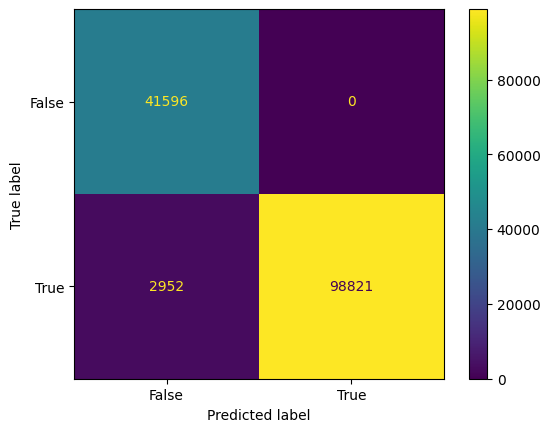

In [197]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [207]:
acc = metrics.accuracy_score(actual,predicted)
pre = metrics.precision_score(actual,predicted)
rec = metrics.recall_score(actual,predicted)
f1  = metrics.f1_score(actual,predicted)

print(f"Accuracy  = {acc:.4f}")
print(f"Precision = {pre:.4f}")
print(f"Recall    = {rec:.4f}")
print(f"F1        = {f1:.4f}")


Accuracy  = 0.9794
Precision = 1.0000
Recall    = 0.9710
F1        = 0.9853


In [208]:
score_p = []
score_n = []
for i in results:
    if i[0]:
        score_p.append(i[1])
    else:
        score_n.append(i[1])


In [209]:
np.max(score_n)

14091.0205

In [210]:
np.min(score_p)

17.427406

In [211]:
np.mean(score_n)

405.4229444101755

In [212]:
np.mean(score_p)

147.83455799785466

In [213]:
f_score_p = []
mean_p = np.mean(score_p)
for i in score_p:
    if i<400:
        f_score_p.append(i)

In [214]:
f_score_n = []
mean_n = np.mean(score_n)
for i in score_n:
    if i<400:
        f_score_n.append(i)

In [215]:
f_score_p = np.array(f_score_p)
f_score_n = np.array(f_score_n)


In [241]:
# Obtiene la información del histograma
valores_p, bordes_p = np.histogram(f_score_p, bins=100, density=True)
centros_p = 0.5 * (bordes_p[:-1] + bordes_p[1:])

# Encuentra el valor máximo en el eje Y
valor_maximo_y_p = max(valores_p)

# Encuentra el valor en el eje X para el cual Y es máximo
valor_maximo_x_p = centros_p[np.argmax(valores_p)]



In [242]:
valor_maximo_x_p

126.40125829

In [243]:
# Obtiene la información del histograma
valores_n, bordes_n = np.histogram(f_score_n, bins=100, density=True)
centros_n = 0.5 * (bordes_n[:-1] + bordes_n[1:])

# Encuentra el valor máximo en el eje Y
valor_maximo_y_n = max(valores_n)

# Encuentra el valor en el eje X para el cual Y es máximo
valor_maximo_x_n = centros_n[np.argmax(valores_n)]

In [244]:
valor_maximo_x_n

33.87606443999999

True

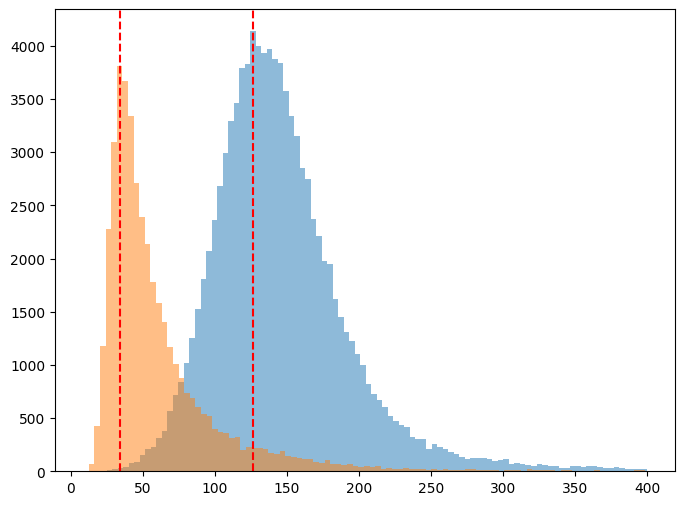

In [245]:
n_bins = 100


plt.figure(figsize=(8,6))
plt.hist(f_score_p, bins=100, alpha=0.5, label="data1", density=False)
plt.hist(f_score_n, bins=100, alpha=0.5, label="data2", density=False)
# Dibuja una línea vertical en el punto máximo
plt.axvline(x=valor_maximo_x_p, color='r', linestyle='--', label=f'Máximo en X: {valor_maximo_x_p:.2f}')
plt.axvline(x=valor_maximo_x_n, color='r', linestyle='--', label=f'Máximo en X: {valor_maximo_x_n:.2f}')

True

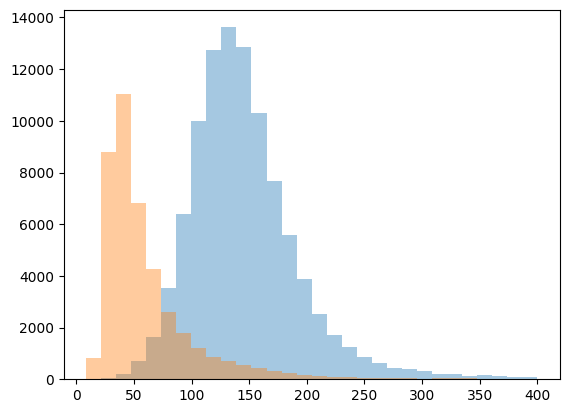

In [217]:
rng = min(f_score_p.min(), f_score_n.min()), max(f_score_p.max(), f_score_n.max())
n1, bins1, _ = plt.hist(f_score_p, alpha=0.4, bins=100, range=rng)
n2, bins2, _ = plt.hist(f_score_n, alpha=0.4, bins=30, range=rng)

10356.0

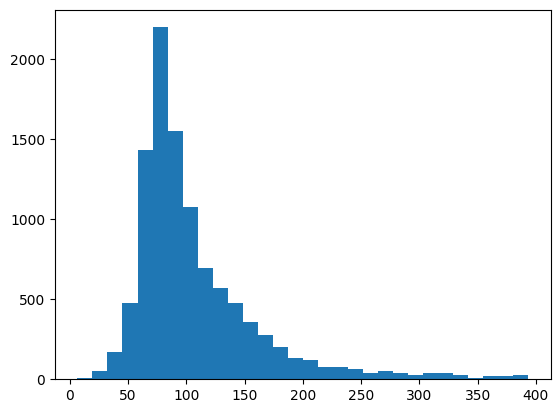

In [167]:
intersection = np.minimum(n1, n2)
area = intersection.sum()
plt.bar(bins1[:-1], intersection, width=bins1[1]- bins1[0])
area

In [168]:
np.max(intersection)

2201.0

In [171]:
bins1


array([ 12.937753  ,  25.83920723,  38.74066147,  51.6421157 ,
        64.54356993,  77.44502417,  90.3464784 , 103.24793263,
       116.14938687, 129.0508411 , 141.95229533, 154.85374957,
       167.7552038 , 180.65665803, 193.55811227, 206.4595665 ,
       219.36102073, 232.26247497, 245.1639292 , 258.06538343,
       270.96683767, 283.8682919 , 296.76974613, 309.67120037,
       322.5726546 , 335.47410883, 348.37556307, 361.2770173 ,
       374.17847153, 387.07992577, 399.98138   ])